In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sporco.dictlrn import dictlrn
from sporco.admm import cbpdn,ccmod
from sporco import cnvrep
from pytictoc import TicToc
import matplotlib.gridspec as gridspec
import pickle
from sporco.admm import cbpdn
from misc import processing

### Initialization and data load

In [3]:
# Init filename and address
file_name = ['nail']
short_axis_length = 20
# Module level constants
eps = 1e-14
lmbda = 1e-1

i = 0

In [4]:
s = processing.load_data(file_name[i], decimation_factor=short_axis_length, data_only= True)
l2f, snorm = processing.to_l2_normed(s)

K = snorm.shape[1]  # number of A-line signal
N = snorm.shape[0]  # length of A-line signgal
M = 1  # state of dictionary
print("file name", file_name)

print("number of A-line signal", K)
print("length of A-line signgal", N)

(330, 10240)
file name ['nail']
number of A-line signal 512
length of A-line signgal 330


### Estimate axial PSF

In [5]:
# randomly select one A-line as the dictionary
dic_index = int(6500/short_axis_length)  # fixed here for repeatability and reproducibility
# l2 normalize the dictionary
D = snorm[:, dic_index]
print(dic_index)

# convert to sporco standard layabout
D = np.reshape(D, (-1, 1, M))

# uniform random sample the training set from input test, 10%
train_index = np.random.choice(snorm.shape[1], int(0.25 * K), replace=False)
s_train = snorm[:, train_index]
Maxiter = 1000
opt_par = cbpdn.ConvBPDN.Options({'FastSolve': True, 'Verbose': True, 'StatusHeader': False,
                                  'MaxMainIter': Maxiter, 'RelStopTol': 5e-5, 'AuxVarObj': True,
                                  'RelaxParam': 1.515, 'AutoRho': {'Enabled': True}})
# convert to sporco standard layabout
s_train = np.reshape(s_train, (-1, 1, len(train_index)))

cri = cnvrep.CDU_ConvRepIndexing(D.shape, s_train)

optx = cbpdn.ConvBPDN.Options({'Verbose': False, 'MaxMainIter': 1,
                               'rho': 8.13e+01, 'AuxVarObj': False})

optd = ccmod.ConvCnstrMODOptions({'Verbose': False, 'MaxMainIter': 1,
                                  'rho': 10, 'ZeroMean': False},
                                 method='cns')
#
# Dictionary support projection and normalisation (cropped).
# Normalise dictionary according to dictionary Y update options.
Dn = cnvrep.Pcn(D, D.shape, cri.Nv, dimN=1, dimC=0, crp=False)

# Update D update options to include initial values for Y and U.
optd.update({'Y0': cnvrep.zpad(cnvrep.stdformD(Dn, cri.Cd, cri.M), cri.Nv),
             'U0': np.zeros(cri.shpD + (cri.K,))})
#
# Create X update object.
xstep = cbpdn.ConvBPDN(Dn, s_train, lmbda, optx)
# # the first one is coefficient map
# #Create D update object. with consensus method
dstep = ccmod.ConvCnstrMOD(None, s_train, D.shape, optd, method='cns')
#
t = TicToc()
t.tic()
opt = dictlrn.DictLearn.Options({'Verbose': False, 'MaxMainIter': Maxiter})
d = dictlrn.DictLearn(xstep, dstep, opt)
D1 = d.solve().squeeze()
D = D.squeeze()

t.toc('DictLearn solve time:')
itsx = xstep.getitstat()
itsd = dstep.getitstat()

axial_PSF = abs(D1)


325


DictLearn solve time: 35.150832 seconds.


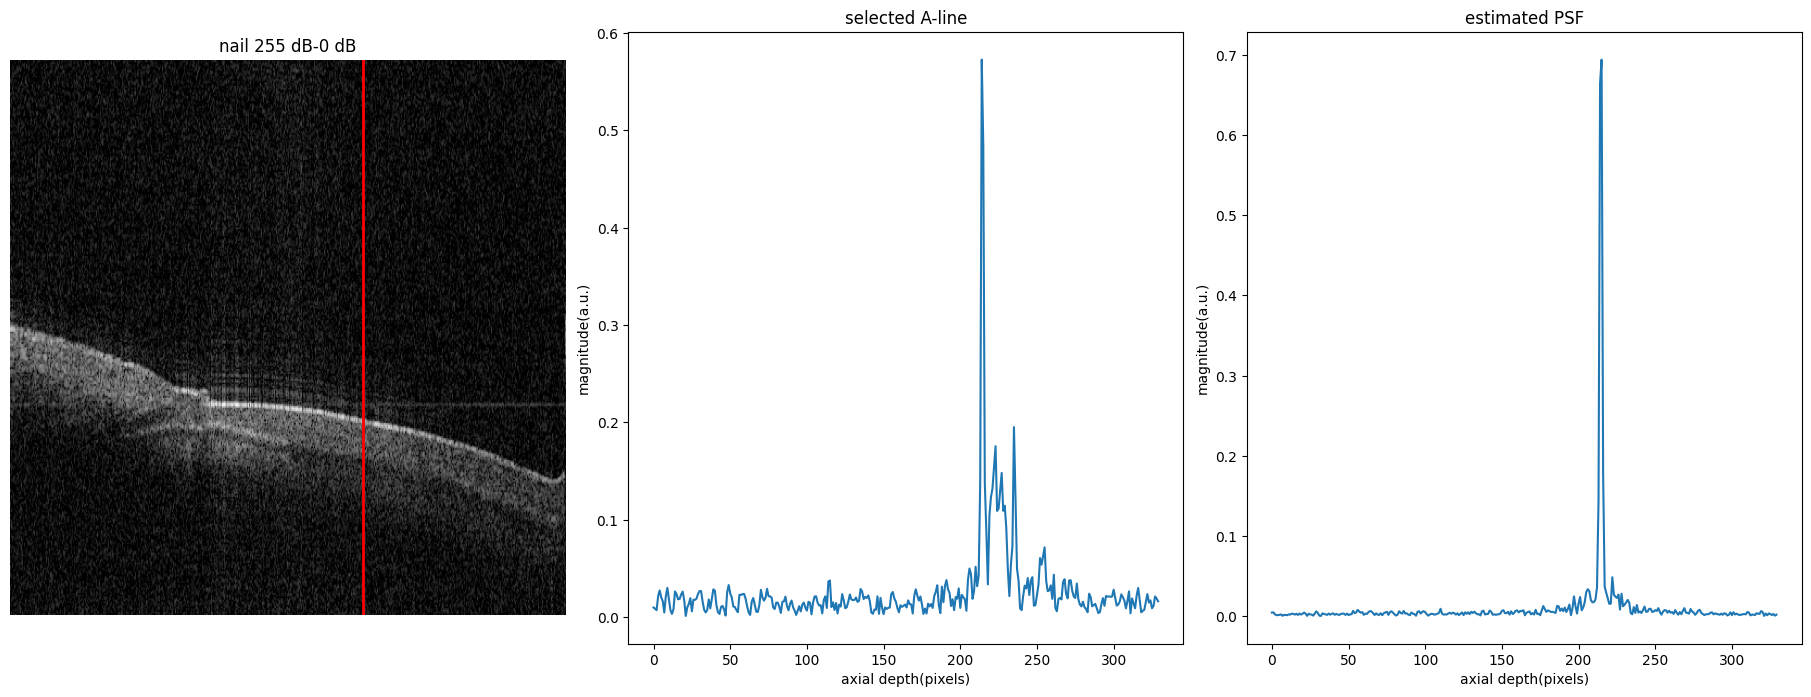

In [6]:
fig = plt.figure(figsize=(18, 13), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig)
# ax = fig.add_subplot(gs[0, :])
# #
# ax.plot(itsx.ObjFun)
# ax.set_ylabel('cost function value')
# ax.set_xlabel('iteration')
# ax.set_title('dictionary learning curve')
#
ax = fig.add_subplot(gs[1, 0])
rvmin, vmax = 5, 55  # dB

s_log = 20 * np.log10(abs(s))
s_log = processing.imag2uint(s_log, rvmin, vmax)

vmin, vmax = 0,255
ax.set_title(file_name[i]+' %d dB-%d dB' % (vmax, vmin))
ax.imshow(s_log, cmap='gray', vmax=vmax, vmin=vmin)
ax.set_aspect(s_log.shape[1] / s_log.shape[0])
ax.axvline(x=dic_index, linewidth=2, color='r')
ax.set_axis_off()
#
ax = fig.add_subplot(gs[1, 1])
ax.set_title('selected A-line')
ax.plot(abs(D))
ax.set_ylabel('magnitude(a.u.)')
ax.set_xlabel('axial depth(pixels)')

ax = fig.add_subplot(gs[1, 2])
ax.set_title('estimated PSF')
ax.plot(abs(D1))
ax.set_ylabel('magnitude(a.u.)')
ax.set_xlabel('axial depth(pixels)')

plt.show()

In [7]:
D1 = D1.reshape(-1, 1)

D_PATH = '../Data/PSF/' + file_name[i]

with open(D_PATH,'wb') as f:
    pickle.dump(D1,f)
    f.close()

### Lateral PSF estimation

In [8]:
# initial parameters
lateral_resolution = 7
pixel_sensitivity = 3/2
radius = (7/2)/pixel_sensitivity
scale_factor = 1 # 1 for non-compressed sensing situation, 10 for compressed sensing situation

psf_size_coeff = 0.5
axial_PSF = abs(D1)
max_val = np.amax(axial_PSF)
focus_pos = np.argmax(axial_PSF)

print("Maximum value:", max_val)
print("Position of maximum value:", focus_pos)
w_0, z_0= radius, focus_pos


Maximum value: 0.6940459958664351
Position of maximum value: 215


In [9]:
# W(z)
def W_z(w_0, z_0, z):
        return w_0 * np.sqrt(1 + (z / z_0)**2)

In [10]:
z = 0
w_z = W_z(w_0, z_0, z)
D = 2 * w_z
r_coord = np.linspace(-psf_size_coeff * D, psf_size_coeff * D, 1 + scale_factor * 2 * np.round(int(psf_size_coeff * D)))
X, Y = np.meshgrid(r_coord, r_coord)
r = np.sqrt(X**2 + Y**2)
PSF_xy = np.exp(-2 * r / w_z)
PSF_xy /= np.sum(PSF_xy)
PSF_x = PSF_xy[len(r_coord) // 2,:]
PSF_y = PSF_xy[len(r_coord) // 2,:]


In [11]:
# # Plot the 2D xy PSF
# plt.imshow(PSF_xy, cmap='hot', extent=[np.min(r_coord), np.max(r_coord), np.min(r_coord), np.max(r_coord)])
# plt.colorbar(label='Intensity')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Point Spread Function')
# plt.show()

In [12]:
# # Plot the PSF along the x-axis
# plt.plot(r_coord, PSF_x)
# plt.xlabel('x')
# plt.ylabel('Intensity')
# plt.title('Point Spread Function along the x-axis')
# plt.show()

In [13]:
def concatenate_1d_arrays(arrays):
    # Determine the maximum size among the arrays
    max_size = max([len(arr) for arr in arrays])
    
    # Pad the smaller arrays with zeros while center-distributing the elements
    padded_arrays = []
    for arr in arrays:
        array_len = len(arr)
        pad_left = (max_size - array_len) // 2
        
        pad_right = max_size - array_len - pad_left
        
        # arr = np.reshape(arr,(array_len,-1))
        padded_array = np.pad(arr, (pad_left, pad_right), mode='constant', constant_values=0)
        # padded_array = padded_array[1,:]
        padded_array = np.reshape(padded_array, (-1, 1))
        padded_arrays.append(padded_array)

    # Find the maximum number of rows required for the padded arrays
    max_rows = max([arr.shape[0] for arr in padded_arrays])

    # Create an empty array to hold the concatenated arrays
    concatenated_array = np.zeros((max_rows, len(padded_arrays)), dtype=np.float64)

    # Fill in the concatenated array with the padded arrays
    for i, arr in enumerate(padded_arrays):
        concatenated_array[:arr.shape[0], i] = arr[:, 0]

    return np.transpose(concatenated_array)

In [18]:
psf_y_array = []
axial_PSF = abs(D1)
max_val = np.amax(axial_PSF)
focus_pos = np.argmax(axial_PSF)
z_0 = focus_pos
max_length = 0
for axial_index in range(axial_PSF.shape[0]):
    
    depth_z = abs(axial_index - z_0)
    w_z = W_z(w_0, z_0, depth_z)
    D = 2 * w_z
    # r_coord = np.linspace(-np.round(int(psf_size_coeff * D)), np.round(int(psf_size_coeff * D)), 1 + scale_factor * 2 * np.round(int(psf_size_coeff * D)))
    r_coord = np.linspace(-psf_size_coeff * D, psf_size_coeff * D, 1 + scale_factor * 2 * np.round(int(psf_size_coeff * D)))

    X, Y = np.meshgrid(r_coord, r_coord)
    r = np.sqrt(X**2 + Y**2)
    PSF_xy = np.exp(-2 * r / w_z)
    PSF_xy /= np.sum(PSF_xy)
    PSF_x = PSF_xy[len(r_coord) // 2,:]
    PSF_y = PSF_xy[len(r_coord) // 2,:]
    PSF_y = np.array(PSF_y / np.sum(PSF_y))
    PSF_y = np.reshape(PSF_y,(1,-1))
    PSF_y = np.squeeze(PSF_y)
    psf_y_array.append(PSF_y)
for arr in psf_y_array:
    print(arr.shape[0])
psf_y_2d = concatenate_1d_arrays(psf_y_array)
num_psfs = psf_y_2d.shape[1]

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [20]:
import math

In [28]:
print(np.shape(psf_y_array[0].T))

(7,)


In [37]:
delta_x = 0
delta_y = psf_y_array[0].shape[0] - math.ceil(psf_y_array[0].shape[0] / 2)
center_x = 20
center_y = 10
input_image = np.zeros((100,50))
scale_factor = 2 
delta_x = 0
delta_y = psf_y_array[0].shape[0] - math.ceil(psf_y_array[0].shape[0] / 2)
    
mask_psf_padded = np.zeros((input_image.shape[0] + 2 * delta_x, input_image.shape[1] + 2 * delta_y))
scaled_xc = center_x * scale_factor 
scaled_yc = center_y * scale_factor 
mask_psf_padded[int(scaled_xc), 
                int(scaled_yc + delta_y - delta_y):int(scaled_yc + delta_y + delta_y+1)] = psf_y_array[0]
                    
mask_psf_i_2 = mask_psf_padded[delta_x:delta_x + input_image.shape[0], 
                               delta_y:delta_y + input_image.shape[1]]
# print("mask_psf_i_2", np.shape(mask_psf_i_2))
sc = mask_psf_i_2.astype(float)


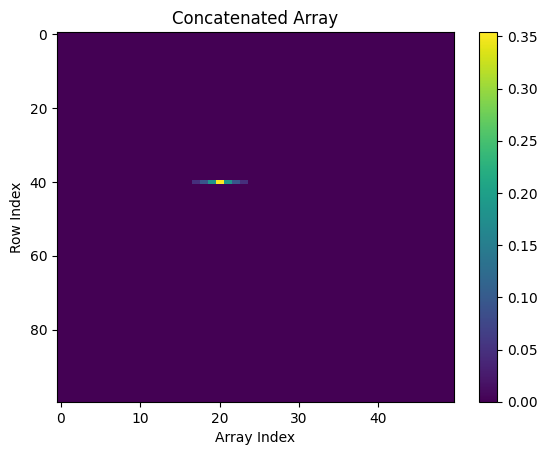

In [38]:
plt.imshow(sc, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Array Index')
plt.ylabel('Row Index')
plt.title('Concatenated Array')
plt.show()

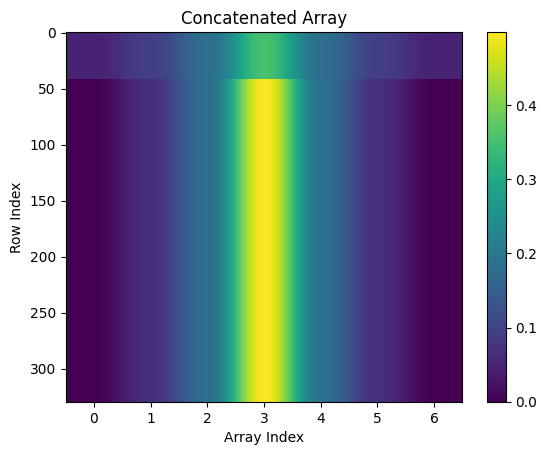

In [15]:
# Plotting
plt.imshow(psf_y_2d, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Array Index')
plt.ylabel('Row Index')
plt.title('Concatenated Array')
plt.show()

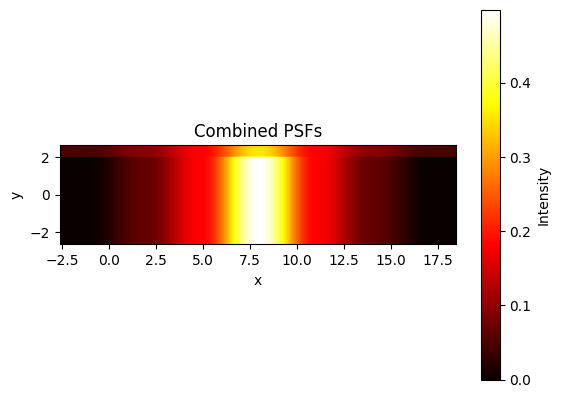

In [16]:
# Plot the combined PSFs
plt.imshow(psf_y_2d, cmap='hot', extent=[np.min(r_coord), np.max(r_coord) * num_psfs, np.min(r_coord), np.max(r_coord)])
plt.colorbar(label='Intensity')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Combined PSFs')
plt.show()